In [1]:
import sys
# !{sys.executable} -m pip install tldextract

<div style='text-align:center;'>
<h1>BioPortal</h1>
<h2>Valid requests</h2>
</div>

In [2]:
__author__ = "Lisette Espin-Noboa"
__copyright__ = "Copyright 2018, HopRank"
__credits__ = ["Florian Lemmerich", "Markus Strohmaier", "Simon Walk", "Mark Musen"]
__license__ = "GPL"
__version__ = "1.0.3"
__maintainer__ = "Lisette Espin-Noboa"
__email__ = "Lisette.Espin@gesis.org"
__status__ = "Developing"

########################################################################################
# Warnings
########################################################################################
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

<h2>Dependencies</h2>

In [27]:
########################################################################################
# System
########################################################################################
import os
import importlib
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
from collections import Counter
from joblib import Parallel, delayed
import matplotlib as mpl
import matplotlib.pyplot as plt 
from collections import defaultdict

########################################################################################
# Local Dependencies
########################################################################################
%reload_ext autoreload
%autoreload 2
from org.gesis.libs.bioportal.ontology import Ontology
from org.gesis.libs.bioportal.transition import Transition
from org.gesis.libs.bioportal.clickstream import NAVITYPES
from org.gesis.libs.bioportal.clickstream import load_clickstream
from org.gesis.libs.bioportal.clickstream import preprocess_clickstream
from org.gesis.libs.bioportal.clickstream import preprocess_sessions
from org.gesis.libs.bioportal.clickstream import clean_clickstream
from org.gesis.libs.bioportal.submission import get_submissions
from org.gesis.libs.utils import log
from org.gesis.libs.utils import weighted_to_undirected
from org.gesis.libs.utils import to_symmetric

########################################################################################
# Plot's style
########################################################################################
sns.set_context(context="paper", font_scale=1.5)
sns.set_style("whitegrid")

<h2>Constants</h2>

In [56]:
SM = 'submission'
SUBMISSIONS_FN = '/bigdata/lespin/datasets/bioportal/submissions.json'

ON = 'ontology'
ONTOLOGY_ROOT = '/bigdata/lespin/datasets/bioportal/ontologies'
ONTOLOGY_GRAPH_OUTPUT = '/bigdata/lespin/bioportal/ontologies/graph'
ONTOLOGY_ADJACENCY_OUTPUT = '/bigdata/lespin/bioportal/ontologies/matrix'
ONTOLOGY_NODES_OUTPUT = '/bigdata/lespin/bioportal/ontologies/nodes'
ONTOLOGY_HOPS_OUTPUT = '/bigdata/lespin/bioportal/ontologies/hops'

CS = 'clickstream'
CS_FN = 'BP_webpage_requests_<YEAR><POSTFIX>.csv.bz2'
CLICKSTREAM_ROOT = '/bigdata/lespin/datasets/bioportal/clickstream/'
CLICKSTREAM_DF = '/bigdata/lespin/bioportal/clickstreams'

TR = 'transitions'
TRANS_GRAPH_OUTPUT = '/bigdata/lespin/bioportal/transitions/graph'
TRANS_ADJACENCY_OUTPUT = '/bigdata/lespin/bioportal/transitions/matrix'
TRANS_NODES_OUTPUT = '/bigdata/lespin/bioportal/transitions/nodes'
LCC_TRANS_GRAPH_OUTPUT = '/bigdata/lespin/bioportal/transitions_in_lcc/graph'
LCC_TRANS_ADJACENCY_OUTPUT = '/bigdata/lespin/bioportal/transitions_in_lcc/matrix'
LCC_TRANS_NODES_OUTPUT = '/bigdata/lespin/bioportal/transitions_in_lcc/nodes'

SU = 'summary'
LOG_OUTPUT = '/bigdata/lespin/bioportal/logs'
PLOTS_OUTPUT = '/bigdata/lespin/bioportal/plots'
SUMMARY_OUTPUT = '/bigdata/lespin/bioportal/summary'
YEAR = '2015'

LAG_BREAK_IN_MINUTES = 60
MIN_SESSION_LENGTH = 2
MIN_REQ = 1000
MIN_TRANSITIONS = 1000

<h2>Functions</h2>

In [46]:
def plot_transitions_per_navitype(clickstreams, transitions, navitypes, fn):
    tmp = {}
    tmp['navitype'] = navitypes
    tmp['ntransitions'] = [transitions[navitype] for navitype in navitypes]
    tmp = pd.DataFrame(tmp)
    ax = sns.barplot(x='navitype',y='ntransitions',
                       data=tmp,
                       order=clickstreams['_navitype'].value_counts().index)
    ax.set_yscale('log')
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_title('Distribution of Transitions per Navigation Type')
    _ = ax.set_ylabel('# transitions')
    _ = ax.set_xlabel('navigation type')
    try:
        id = round(tmp.navitype.nunique()/2.)-1
        ax.text( id, tmp.loc[id,'ntransitions'], '{:,} (valid) transitions'.format(int(transitions[None])))
    except Exception as ex:
        print(ex)
        pass

    plt.tight_layout()
    plt.savefig(fn, bbox_inches='tight')
    
def plot_transitions_per_ontology_and_navitype(df, values, onto_order, fn):
    navitypes_order = ['DE','DC','DU','EX','EL','ES','LS']
    tmp = df.pivot(columns='ontology',
                   index='navitype',
                   values=values).fillna(0).reindex(index = navitypes_order)[onto_order]
    ax = tmp.divide(tmp.sum(axis=0),axis=1).T.plot.bar(stacked=True, linewidth=0.0, figsize=(7.8,5))
    _ = ax.legend(frameon=False, bbox_to_anchor=(1.01,0.5), loc="center left", borderaxespad=0, title='navitype')
    ax.grid(False)
    plt.tight_layout()
    plt.savefig(fn, bbox_inches='tight')

<div style='text-align:center;'>
<h1>Submissions</h1>
</div>

In [5]:
%%capture cap --no-stderr
submissions_dict = get_submissions(SUBMISSIONS_FN)

In [6]:
print(cap.stdout)
log(LOG_OUTPUT, SM, cap)
del(cap)

2019-02-03 00:24:47	/bigdata/lespin/datasets/bioportal/submissions.json loaded!
2019-02-03 00:24:47	- 642 ontologies
2019-02-03 00:24:47	- 13 years

2019-02-03 00:24:47	/bigdata/lespin/bioportal/logs/submission_2019-02-03_00.log saved!


<div style='text-align:center;'>
<h1>Clickstreams</h1>
</div>

In [7]:
fn = CS_FN.replace('<YEAR>',YEAR).replace('<POSTFIX>','_parsed_sessions_prevalid')
fn = os.path.join(CLICKSTREAM_DF,fn)
if os.path.exists(fn):
    print('loading...')
    valid_clickstreams = pd.read_csv(fn, compression='bz2')
    print('{} loaded!'.format(fn))
else:
    print('{} does NOT exist!'.format(fn))

loading...
/bigdata/lespin/bioportal/clickstreams/BP_webpage_requests_2015_parsed_sessions_prevalid.csv.bz2 loaded!


<div style='text-align:center;'>
<h1>Ontology</h1>
</div>

In [8]:
%%capture cap --no-stderr
onto_name = 'CPT'
submission = submissions_dict[onto_name][YEAR]
onto = Ontology(name=onto_name, year=YEAR, submission_id=submission['submissionId'], root_folder=ONTOLOGY_ROOT)
onto.load_ontology()
onto.create_adjacency_matrix()
onto.create_adjacency_matrix(lcc=True)
onto.save_graph(path=ONTOLOGY_GRAPH_OUTPUT)
onto.save_adjacency(path=ONTOLOGY_ADJACENCY_OUTPUT)
onto.save_adjacency(path=ONTOLOGY_ADJACENCY_OUTPUT, lcc=True)
onto.save_nodes(path=ONTOLOGY_NODES_OUTPUT)
onto.save_nodes(path=ONTOLOGY_NODES_OUTPUT, lcc=True)
print(onto.A.shape)
print(onto.lcc_A.shape)

In [9]:
print(cap.stdout)
log(LOG_OUTPUT, ON, cap)
del(cap)

2019-02-03 00:25:36	/bigdata/lespin/datasets/bioportal/ontologies/CPT/6/CPT.csv.gz loaded!
2019-02-03 00:25:40	Convertion CPT-2015 DataFrame to DiGraph done!
2019-02-03 00:25:41	/bigdata/lespin/bioportal/ontologies/graph/CPT_2015.gpickle saved!
2019-02-03 00:25:41	/bigdata/lespin/bioportal/ontologies/matrix/CPT_2015.mtx saved!
2019-02-03 00:25:41	/bigdata/lespin/bioportal/ontologies/matrix/LCC_CPT_2015.mtx saved!
2019-02-03 00:25:41	/bigdata/lespin/bioportal/ontologies/nodes/CPT_2015.csv saved!
2019-02-03 00:25:42	/bigdata/lespin/bioportal/ontologies/nodes/LCC_CPT_2015.csv saved!
(13219, 13219)
(13092, 13092)

2019-02-03 00:25:42	/bigdata/lespin/bioportal/logs/ontology_2019-02-03_00.log saved!


<div style='text-align:center;'>
<h1>Transitions by Ontology (LCC)</h1>
</div>

In [10]:
%%capture cap --no-stderr
navitype = None

# all transitions
cs = Transition(onto_name, navitype, YEAR)
cs.load_clickstream_and_validate(valid_clickstreams,onto.sorted_nodes,MIN_SESSION_LENGTH)
cs.create_adjacency_matrix(sorted_nodes=onto.sorted_nodes)
cs.save_graph(path=TRANS_GRAPH_OUTPUT)
cs.save_adjacency(path=TRANS_ADJACENCY_OUTPUT)
cs.save_nodes(path=TRANS_NODES_OUTPUT)
print(nx.info(cs.H))
print(cs.H.size(weight='weight'))
print(cs.T.shape)

# LCC transitions
cs = Transition(onto_name, navitype, YEAR)
cs.load_clickstream_and_validate(valid_clickstreams,onto.lcc_sorted_nodes,MIN_SESSION_LENGTH)
cs.create_adjacency_matrix(sorted_nodes=onto.lcc_sorted_nodes)
cs.save_graph(path=LCC_TRANS_GRAPH_OUTPUT)
cs.save_adjacency(path=LCC_TRANS_ADJACENCY_OUTPUT)
cs.save_nodes(path=LCC_TRANS_NODES_OUTPUT)
print(nx.info(cs.H))
print(cs.H.size(weight='weight'))
print(cs.T.shape)

In [11]:
print(cap.stdout)
log(LOG_OUTPUT, TR, cap)
del(cap)

2019-02-03 00:26:46	CPT-2015-None: 10231 concepts found, but 10075 kept (cros-val)
2019-02-03 00:26:47	/bigdata/lespin/bioportal/transitions/graph/CPT_2015_ALL.gpickle saved!
2019-02-03 00:26:47	/bigdata/lespin/bioportal/transitions/matrix/CPT_2015_ALL.mtx saved!
2019-02-03 00:26:47	/bigdata/lespin/bioportal/transitions/nodes/CPT_2015_ALL.csv saved!
Name: 
Type: DiGraph
Number of nodes: 10075
Number of edges: 33140
Average in degree:   3.2893
Average out degree:   3.2893
44815.0
(13219, 13219)
2019-02-03 00:27:51	CPT-2015-None: 10231 concepts found, but 10058 kept (cros-val)
2019-02-03 00:27:51	/bigdata/lespin/bioportal/transitions_in_lcc/graph/CPT_2015_ALL.gpickle saved!
2019-02-03 00:27:52	/bigdata/lespin/bioportal/transitions_in_lcc/matrix/CPT_2015_ALL.mtx saved!
2019-02-03 00:27:52	/bigdata/lespin/bioportal/transitions_in_lcc/nodes/CPT_2015_ALL.csv saved!
Name: 
Type: DiGraph
Number of nodes: 10058
Number of edges: 32987
Average in degree:   3.2797
Average out degree:   3.2797
4465

<div style='text-align:center; color:red;'>
<h1>Valid Ontologies & Transitions</h1>
<h2>Cross-validation</h2>
</div>

In [12]:
valid_ontologies_clickstream = valid_clickstreams.groupby('_ontology').filter(lambda x: len(x) >= MIN_REQ)
print('{} valid ontologies'.format(valid_ontologies_clickstream._ontology.nunique()))
print('{} valid requests'.format(valid_ontologies_clickstream.shape))

67 valid ontologies
(1209217, 22) valid requests


In [13]:
%%capture cap --no-stderr

all_transitions = defaultdict(lambda:0)
lcc_transitions = defaultdict(lambda:0)

for onto_name in valid_ontologies_clickstream._ontology.unique():
    ### Onotlogy
    print('\n\n')
    print("***********************************************")
    print(onto_name)
    print("***********************************************")
    try:
        # ontology
        submission = submissions_dict[onto_name][YEAR]
        onto = Ontology(name=onto_name, year=YEAR, submission_id=submission['submissionId'], root_folder=ONTOLOGY_ROOT)
        onto.load_ontology()
        onto.create_adjacency_matrix()
        onto.create_adjacency_matrix(lcc=True)
        onto.save_graph(path=ONTOLOGY_GRAPH_OUTPUT)
        onto.save_adjacency(path=ONTOLOGY_ADJACENCY_OUTPUT)
        onto.save_adjacency(path=ONTOLOGY_ADJACENCY_OUTPUT, lcc=True)
        onto.save_nodes(path=ONTOLOGY_NODES_OUTPUT)
        onto.save_nodes(path=ONTOLOGY_NODES_OUTPUT, lcc=True)
        
    except Exception as ex:
        onto = None
        print(ex)
    
    ### Transitions per navigation type
    if onto is not None:
        for navitype in [None]+NAVITYPES:
            print("==================")
            print(navitype)
            print("==================")

            try:
                # all transitions
                cs = Transition(onto_name, navitype, YEAR)
                cs.load_clickstream_and_validate(valid_clickstreams,onto.sorted_nodes,MIN_SESSION_LENGTH)            
                cs.create_adjacency_matrix(sorted_nodes=onto.sorted_nodes)
                cs.save_graph(path=TRANS_GRAPH_OUTPUT)
                cs.save_adjacency(path=TRANS_ADJACENCY_OUTPUT)
                cs.save_nodes(path=TRANS_NODES_OUTPUT)
                all_transitions[navitype] += cs.T.sum()
                
                # transitions in LCC
                cs.set_nodes(onto.lcc_sorted_nodes)
                cs.create_adjacency_matrix(sorted_nodes=onto.lcc_sorted_nodes)
                cs.save_adjacency(path=LCC_TRANS_ADJACENCY_OUTPUT)
                cs.save_nodes(path=LCC_TRANS_NODES_OUTPUT)
                lcc_transitions[navitype] += cs.T.sum()
                del(cs)
                
            except Exception as ex:
                print(ex)
    del(onto)
    print('{} all transitions (so far)\n'.format(all_transitions[navitype]))
    print('{} lcc transitions (so far)\n'.format(lcc_transitions[navitype]))

In [14]:
print(cap.stdout)
log(LOG_OUTPUT, ON, cap)
del(cap)




***********************************************
SNOMEDCT
***********************************************
2019-02-03 00:28:25	/bigdata/lespin/datasets/bioportal/ontologies/SNOMEDCT/11/SNOMEDCT.csv.gz loaded!
2019-02-03 00:30:17	Convertion SNOMEDCT-2015 DataFrame to DiGraph done!
2019-02-03 00:31:22	/bigdata/lespin/bioportal/ontologies/graph/SNOMEDCT_2015.gpickle saved!
2019-02-03 00:31:25	/bigdata/lespin/bioportal/ontologies/matrix/SNOMEDCT_2015.mtx saved!
2019-02-03 00:31:28	/bigdata/lespin/bioportal/ontologies/matrix/LCC_SNOMEDCT_2015.mtx saved!
2019-02-03 00:31:30	/bigdata/lespin/bioportal/ontologies/nodes/SNOMEDCT_2015.csv saved!
2019-02-03 00:31:31	/bigdata/lespin/bioportal/ontologies/nodes/LCC_SNOMEDCT_2015.csv saved!
None
2019-02-03 00:33:10	SNOMEDCT-2015-None: 51457 concepts found, but 51297 kept (cros-val)
2019-02-03 00:33:11	/bigdata/lespin/bioportal/transitions/graph/SNOMEDCT_2015_ALL.gpickle saved!
2019-02-03 00:33:12	/bigdata/lespin/bioportal/transitions/matrix/SNOMEDCT_

In [15]:
all_transitions

defaultdict(<function __main__.<lambda>()>,
            {'DC': 17677,
             'DE': 57683,
             'DU': 73608,
             'EL': 959.0,
             'ES': 14287.0,
             'EX': 116876,
             'HS': 165.0,
             'LS': 64303,
             None: 345558})

In [16]:
lcc_transitions

defaultdict(<function __main__.<lambda>()>,
            {'DC': 17229.0,
             'DE': 34343.0,
             'DU': 38654.0,
             'EL': 490.0,
             'ES': 5323.0,
             'EX': 108151.0,
             'HS': 108.0,
             'LS': 40880.0,
             None: 245178.0})

<h2># Transitions per navigation type</h2>

<h3>Valid transitions: All visited concepts</h3>

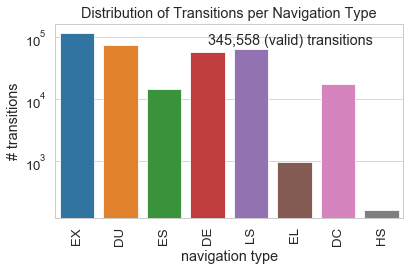

In [30]:
fn = os.path.join(PLOTS_OUTPUT,'summary_navitypes_valid_transitions_{}.pdf'.format(YEAR))
plot_transitions_per_navitype(valid_clickstreams, all_transitions, NAVITYPES, fn)

<h3>Valid transitions: LCC visited concepts</h3>

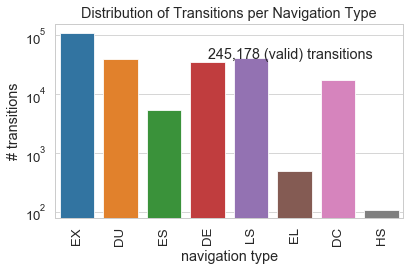

In [31]:
fn = os.path.join(PLOTS_OUTPUT,'lcc_summary_navitypes_valid_transitions_{}.pdf'.format(YEAR))
plot_transitions_per_navitype(valid_clickstreams, lcc_transitions, NAVITYPES, fn)

<h2># Transitions per ontology</h2>

In [59]:
%%capture cap --no-stderr
columns = ['ontology','navitype','ntransitions','lcc_ntransitions']
df_trans = pd.DataFrame(columns=columns)

for onto_name in valid_ontologies_clickstream._ontology.unique():
    for navitype in [None] + NAVITYPES:
        try:
            # all transitions
            cs = Transition(onto_name, navitype, YEAR)            
            cs.load_adjacency(path=LCC_TRANS_ADJACENCY_OUTPUT)
            lccntrans = cs.T.sum()
            cs.load_adjacency(path=TRANS_ADJACENCY_OUTPUT)
            ntrans = cs.T.sum()
            
            if cs.T is not None:
                df_trans = df_trans.append({'ontology':onto_name,
                                            'navitype':'ALL' if navitype is None else navitype,
                                            'ntransitions':ntrans,
                                            'lcc_ntransitions':lccntrans
                                            }, ignore_index=True)
            del(cs)
        except Exception as ex:
            print(ex)

In [60]:
print(cap.stdout)
log(LOG_OUTPUT, ON, cap)
del(cap)

2019-02-03 02:53:57	/bigdata/lespin/bioportal/transitions_in_lcc/matrix/SNOMEDCT_2015_ALL.mtx loaded!
2019-02-03 02:53:57	/bigdata/lespin/bioportal/transitions/matrix/SNOMEDCT_2015_ALL.mtx loaded!
2019-02-03 02:53:57	/bigdata/lespin/bioportal/transitions_in_lcc/matrix/SNOMEDCT_2015_DC.mtx loaded!
2019-02-03 02:53:57	/bigdata/lespin/bioportal/transitions/matrix/SNOMEDCT_2015_DC.mtx loaded!
2019-02-03 02:53:57	/bigdata/lespin/bioportal/transitions_in_lcc/matrix/SNOMEDCT_2015_DE.mtx loaded!
2019-02-03 02:53:57	/bigdata/lespin/bioportal/transitions/matrix/SNOMEDCT_2015_DE.mtx loaded!
2019-02-03 02:53:58	/bigdata/lespin/bioportal/transitions_in_lcc/matrix/SNOMEDCT_2015_EX.mtx loaded!
2019-02-03 02:53:58	/bigdata/lespin/bioportal/transitions/matrix/SNOMEDCT_2015_EX.mtx loaded!
2019-02-03 02:53:58	/bigdata/lespin/bioportal/transitions_in_lcc/matrix/SNOMEDCT_2015_DU.mtx loaded!
2019-02-03 02:53:58	/bigdata/lespin/bioportal/transitions/matrix/SNOMEDCT_2015_DU.mtx loaded!
2019-02-03 02:53:58	/bi

In [61]:
df_trans.head()

,ontology,navitype,ntransitions,lcc_ntransitions
0,SNOMEDCT,ALL,110859,110441
1,SNOMEDCT,DC,5241,5216
2,SNOMEDCT,DE,10282,10110
3,SNOMEDCT,EX,55174,55069
4,SNOMEDCT,DU,23343,23318


<h3>Valid transitions: All visited concepts</h3>

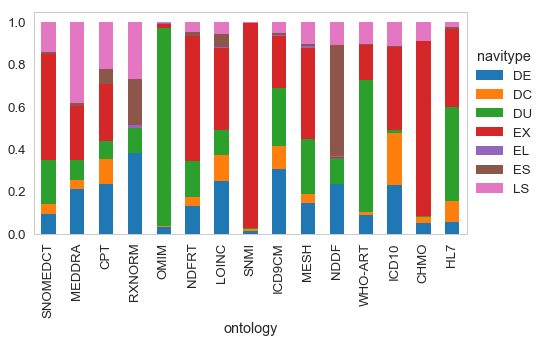

In [90]:
tmp = df_trans.query("navitype != 'ALL'")
sorted_ontos = tmp.groupby('ontology').ntransitions.sum().reset_index()
sorted_ontos.sort_values('ntransitions', ascending=False, inplace=True)
sorted_valid_ontos = sorted_ontos.query("ntransitions>=@MIN_TRANSITIONS")

fn = os.path.join(PLOTS_OUTPUT,'summary_navitypes_valid_transitions_per_ontology_{}.pdf'.format(YEAR))
plot_transitions_per_ontology_and_navitype(tmp, 'ntransitions', sorted_valid_ontos.ontology, fn)

<h3>Valid transitions: LCC visited concepts</h3>

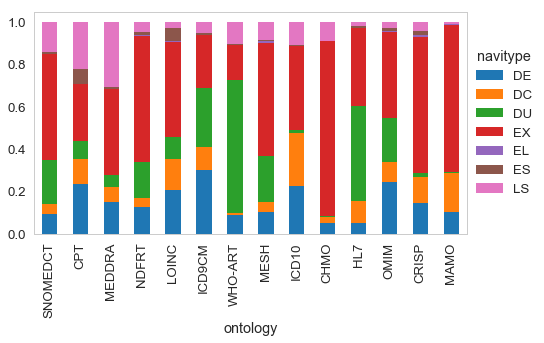

In [91]:
tmp = df_trans.query("navitype != None")
sorted_ontos = tmp.groupby('ontology').lcc_ntransitions.sum().reset_index()
sorted_ontos.sort_values('lcc_ntransitions', ascending=False, inplace=True)
sorted_valid_ontos = sorted_ontos.query("lcc_ntransitions>=@MIN_TRANSITIONS")

fn = os.path.join(PLOTS_OUTPUT,'lcc_summary_navitypes_valid_transitions_per_ontology_{}.pdf'.format(YEAR))
plot_transitions_per_ontology_and_navitype(tmp, 'lcc_ntransitions', sorted_valid_ontos.ontology, fn)

<h2>Summary Table</h2>

In [75]:
##########################################################################################
### N: number of nodes
### E: number of edges
### k: average degree
### nc: number of connected components
### T: number of transitions
##########################################################################################

columns = ['ontology','N','E','k','cc','T', "N'","E'","k'","T'"]
df_onto = pd.DataFrame(columns=columns)
for onto_name in df_trans.ontology.unique():
    print(onto_name)
    try:
        # ontology
        submission = submissions_dict[onto_name][YEAR]
        onto = Ontology(name=onto_name, year=YEAR, submission_id=submission['submissionId'], root_folder=ONTOLOGY_ROOT)
        onto.load_adjacency(path=ONTOLOGY_ADJACENCY_OUTPUT)
        onto.load_adjacency(path=ONTOLOGY_ADJACENCY_OUTPUT, lcc=True)
        onto.load_graph(path=ONTOLOGY_GRAPH_OUTPUT)
        ncomponents = nx.number_connected_components(onto.G.to_undirected())
        del(onto.G)
        
        # transitions
        try: 
            tmp = df_trans.query("ontology==@onto_name & navitype=='ALL'")
            ntrans = tmp.ntransitions
            lcc_ntrans = tmp.lcc_ntransitions
        except Exception as ex: 
            ntrans = 0
            lcc_ntrans = 0
            print(ex)
        
        # summary
        df_onto = df_onto.append({ 'ontology':onto_name,
                                   'N':onto.A.shape[0],
                                   'E':onto.A.sum(),
                                   'k':2*onto.A.sum()/onto.A.shape[0],
                                   'cc':ncomponents,
                                   'T':ntrans,
                                   "N'":onto.lcc_A.shape[0],
                                   "E'":onto.lcc_A.sum(),
                                   "k'":2*onto.lcc_A.sum()/onto.lcc_A.shape[0],
                                   "T'":lcc_ntrans,
                              }, ignore_index=True)
        
        del(onto)
        
    except Exception as ex:
        print(ex)
        

SNOMEDCT
2019-02-03 03:09:49	/bigdata/lespin/bioportal/ontologies/matrix/SNOMEDCT_2015.mtx loaded!
2019-02-03 03:09:52	/bigdata/lespin/bioportal/ontologies/matrix/LCC_SNOMEDCT_2015.mtx loaded!
2019-02-03 03:09:56	/bigdata/lespin/bioportal/ontologies/graph/SNOMEDCT_2015.gpickle loaded!
CPT
2019-02-03 03:10:14	/bigdata/lespin/bioportal/ontologies/matrix/CPT_2015.mtx loaded!
2019-02-03 03:10:14	/bigdata/lespin/bioportal/ontologies/matrix/LCC_CPT_2015.mtx loaded!
2019-02-03 03:10:14	/bigdata/lespin/bioportal/ontologies/graph/CPT_2015.gpickle loaded!
ICD10
2019-02-03 03:10:15	/bigdata/lespin/bioportal/ontologies/matrix/ICD10_2015.mtx loaded!
2019-02-03 03:10:15	/bigdata/lespin/bioportal/ontologies/matrix/LCC_ICD10_2015.mtx loaded!
2019-02-03 03:10:15	/bigdata/lespin/bioportal/ontologies/graph/ICD10_2015.gpickle loaded!
RXNORM
2019-02-03 03:10:15	/bigdata/lespin/bioportal/ontologies/matrix/RXNORM_2015.mtx loaded!
2019-02-03 03:10:15	/bigdata/lespin/bioportal/ontologies/matrix/LCC_RXNORM_2015

In [ ]:
df_onto.reset_index(drop=True,inplace=True)
df_onto.rename(columns={'index':'#'}, inplace=True)

df_onto.loc[:,'T'] = df_onto['T'].astype(np.int)
df_onto.loc[:,"T'"] = df_onto["T'"].astype(np.int)
df_onto=df_onto[['#']+columns]

In [89]:
df_onto.sort_values("T'", ascending=False, inplace=True)
df_onto.reset_index(inplace=True, drop=True)
df_onto.loc[:,'#'] = df_onto.index + 1 
df_onto


,#,ontology,N,E,k,cc,T,N',E',k',T'
0,1,SNOMEDCT,315684,467027,2.958826,60,110859,315205,466607,2.960657,110441
1,2,CPT,13219,13235,2.002421,3,44815,13092,13110,2.002750,44651
2,3,MEDDRA,66506,31863,0.958199,43493,71580,22889,31738,2.773210,42746
3,4,NDFRT,35019,34504,1.970587,522,24662,32074,32080,2.000374,22452
4,5,LOINC,174513,152683,1.749818,73518,7905,100871,152558,3.024814,6349
5,6,ICD9CM,22534,22531,1.999734,3,4485,22407,22406,1.999911,4434
6,7,WHO-ART,1852,2997,3.236501,3,2826,1725,2872,3.329855,2811
7,8,MESH,165166,24182,0.292821,145652,3842,16947,21596,2.548652,2623
8,9,ICD10,12446,11256,1.808774,1190,2328,11132,11131,1.999820,2288
9,10,CHMO,2966,3071,2.070802,3,1423,2964,3071,2.072200,1423


In [83]:
%%capture cap --no-stderr

fn = os.path.join(SUMMARY_OUTPUT,'summary_ontologies_transitions_{}.{}'.format(YEAR,'csv'))
df_onto.to_csv(fn, index=None)
print('{} saved!'.format(fn))

fn = os.path.join(SUMMARY_OUTPUT,'summary_ontologies_transitions_{}.{}'.format(YEAR,'latex'))
txt = df_onto.to_latex(index=False, float_format=lambda x: '%.2f' % x, bold_rows=[0])
with open(fn, 'w') as f:
    f.write(txt)
    f.write('\n')
print('{} saved!'.format(fn))

In [84]:
print(cap.stdout)
log(LOG_OUTPUT, SU, cap)
del(cap)

/bigdata/lespin/bioportal/summary/summary_ontologies_transitions_2015.csv saved!
/bigdata/lespin/bioportal/summary/summary_ontologies_transitions_2015.latex saved!

2019-02-03 03:22:59	/bigdata/lespin/bioportal/logs/summary_2019-02-03_03.log saved!


In [85]:
df_onto.mean()

#        11.000000
N     54309.000000
E     41814.904762
k         1.715359
cc    23245.857143
T     16455.142857
N'    28706.285714
E'    39455.666667
k'        2.414027
T'    11675.142857
dtype: float64